In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec

import os
import pandas as pd
from typing import Tuple
from termcolor import colored
from pathlib import Path

from scipy.interpolate import interp1d
from scipy.integrate import trapz, quad

## ----- IMPORT DES FONCTIONS ----- ##

from dimensioning_functions.generate_Cx_Isp import generate_Cx_Isp
from dimensioning_functions.constraint_algo import constraints_algo
from dimensioning_functions.generate_csv_txt import generate_csv_txt
from dimensioning_functions.constraint_graphs import constraint_graphs

from design_functions.generate_missile_sections import generate_missile_section
from design_functions.generate_ogive_shape import generate_ogive_shape
from design_functions.generate_CG_missile import generate_CG_missile

from air_intakes_functions.External_diameter import Get_external_diameter
from air_intakes_functions.Internal_diameter import Get_internal_diameter
from air_intakes_functions.AirIntakes_thickness import Get_AI_thickness

from aero_function.Get_aero_components import Get_aero_components
from aero_function.Get_Steering_Angle import Get_Steering_Angle
from aero_function.Get_Data_section import Get_Data_section
from aero_function.Get_drag_data import Get_drag_data

## -------------------------------- ##


<div class="alert alert-info" align="center"><b>STOCKAGE DES INFORMATIONS</b></div>

In [2]:
docs_path = Path.cwd().parent / "Docs"
img_path = docs_path / "img"
resultats_path = docs_path / "resultats"

# Création des dossiers si nécessaire
for path in [docs_path, img_path, resultats_path]:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Le dossier {colored(path.name, 'green')} a été créé.")
    else:
        print(f"Le dossier {colored(path.name, 'yellow')} existe déjà.")

Le dossier Docs existe déjà.
Le dossier img existe déjà.
Le dossier resultats existe déjà.


<div class="alert alert-info" align="center"><b>SYNTHESE CONTRAINTE VARIABLES DU MISSILE - MOTEUR : STATORÉACTEUR</b></div>

In [3]:
## DONNÉES
t_acc = 4.85655564067031
t_cruise = 143.82010925319975
t_mission = t_acc + t_cruise

    # thermophysique
gamma = 1.4
P_amb = 101325
T_amb = 288
r_air = 8.314 / (28.966*1e-3)
g0 = 9.80665
Mach_cruise = 2.0
Mach_acc = 0.6
V_son = np.sqrt(gamma * r_air * T_amb)
Delta_Vr = (Mach_cruise - Mach_acc) * V_son

    # Impulsion spécifique
Isp_acc = 240

    # masse volumique
rho_a = 1800
rho_c = 1000
rho_payload = 3000
rho_equipement = 1500

    # masses
m_ogive = 25
m_equipement = 55
m_payload = 200
m_engine_h = 10
m_nozzle = 12
m_tails = 16

    # coefficient
c_a = 0.7
i_a = 0.28
c_c = 0.9
i_c = 0.22

    # diamètre vecteur
dt = 0.001
d_missile = np.arange(0.2, 0.6 + dt, dt)
shape = d_missile.shape[0]


<div class="alert alert-success" align="center"><b>PARAMÈTRES DE LA SIMULATION</b></div>

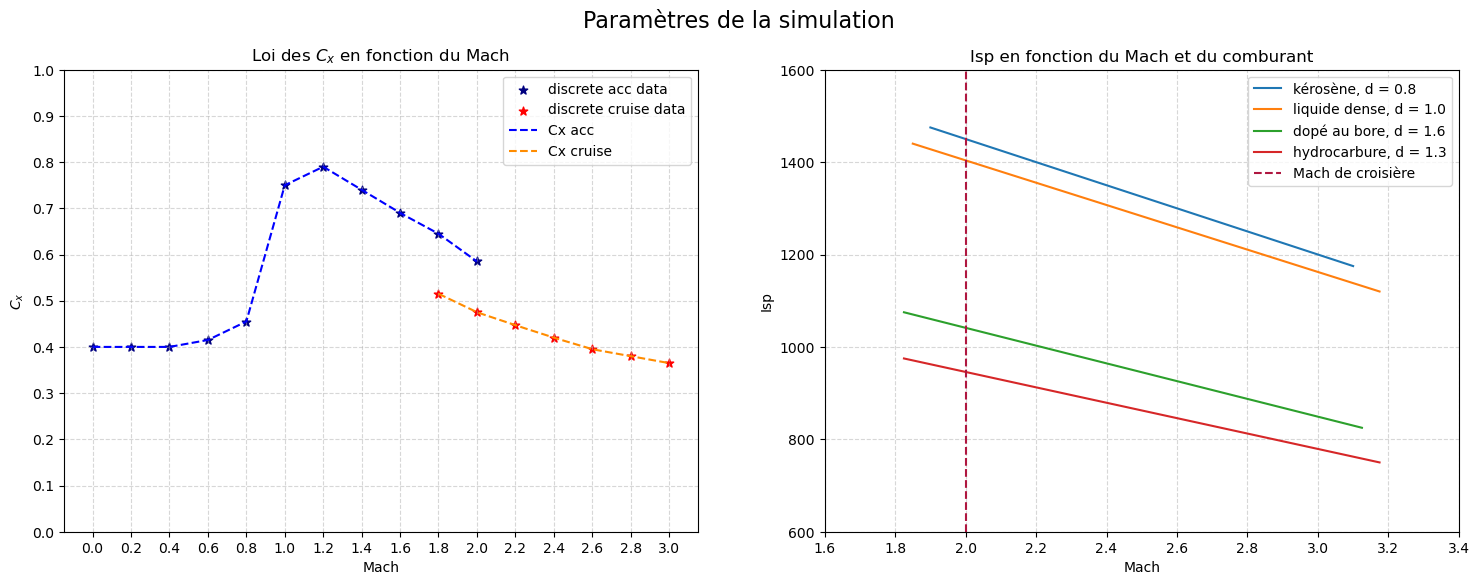

In [4]:
from dimensioning_functions.generate_Cx_Isp import generate_Cx_Isp

keys_dict_main, cruise_data_dict, Cx_acc_arr, Mach_acc_arr, isp_value, Cd_c, densite_value = generate_Cx_Isp(Mach_cruise=Mach_cruise, shape=d_missile.shape[0], 
                                                                                                             img_path=img_path)

time = {
    't_acc': t_acc,
    't_cruise': t_cruise,
}

data_mission = {
    'gamma': gamma,
    'P_amb': P_amb,
    'Mach_cruise': Mach_cruise,
    'g0': g0,
    'Cd_c': Cd_c,
    'Delta_Vr': Delta_Vr,
    'Isp_acc': Isp_acc,
    'mass': {
        'm_ogive': m_ogive,
        'm_equipement': m_equipement,
        'm_tails': m_tails,
        'm_payload': m_payload,
        'm_engine_h': m_engine_h,
        'm_nozzle': m_nozzle
    },
    'rho': {
        'rho_payload': rho_payload,
        'rho_equipement': rho_equipement,
        'rho_c': rho_c,
        'rho_a': rho_a
    }
}

c = {
    'c_a': c_a,
    'c_c': c_c
}

i = {
    'i_a': i_a,
    'i_c': i_c
}

graph_component = {
    'Mach_acc_arr': Mach_acc_arr,
    'Cx_acc_arr': Cx_acc_arr
}

iterate = {
    'keys_dict_main': keys_dict_main,
    'cruise_data_dict': cruise_data_dict
}

<div class="alert alert-info" align="center"><b>CONTRAINTES DU MISSILE</b></div>

In [5]:
mass_tensor, length_tensor, d_missile = constraints_algo(time=time, data_mission=data_mission, c=c, i=i, graph_component=graph_component, iterate=iterate)

In [6]:
generate_csv_txt(cruise_data_dict=cruise_data_dict, d_missile=d_missile, 
                 data_mission=data_mission, length_tensor=length_tensor, 
                 mass_tensor=mass_tensor, isp_value=isp_value, 
                 densite_value=densite_value, resultats_path=resultats_path, c=c)

In [7]:
## ----- OXYDANT ----- ## 
# "Kerosene", "Liquide dense", "Bore", "Hydrocarbure"

oxydizer = "Liquide dense"
idx_chosen_oxydizer = np.where(keys_dict_main == oxydizer)[0]

## ----- CHARGEMENT DU FICHIER ----- ##
results_path = os.path.join(resultats_path, f"{oxydizer}.csv")
results_df = pd.read_csv(results_path, sep="\t")

## ----- CARCATÉRISTIQUES DU MISSILE ----- ##
diametre = 0.35
idx_diametre = np.argmin(np.abs(results_df['d_m'] - diametre))
row = results_df.iloc[idx_diametre]

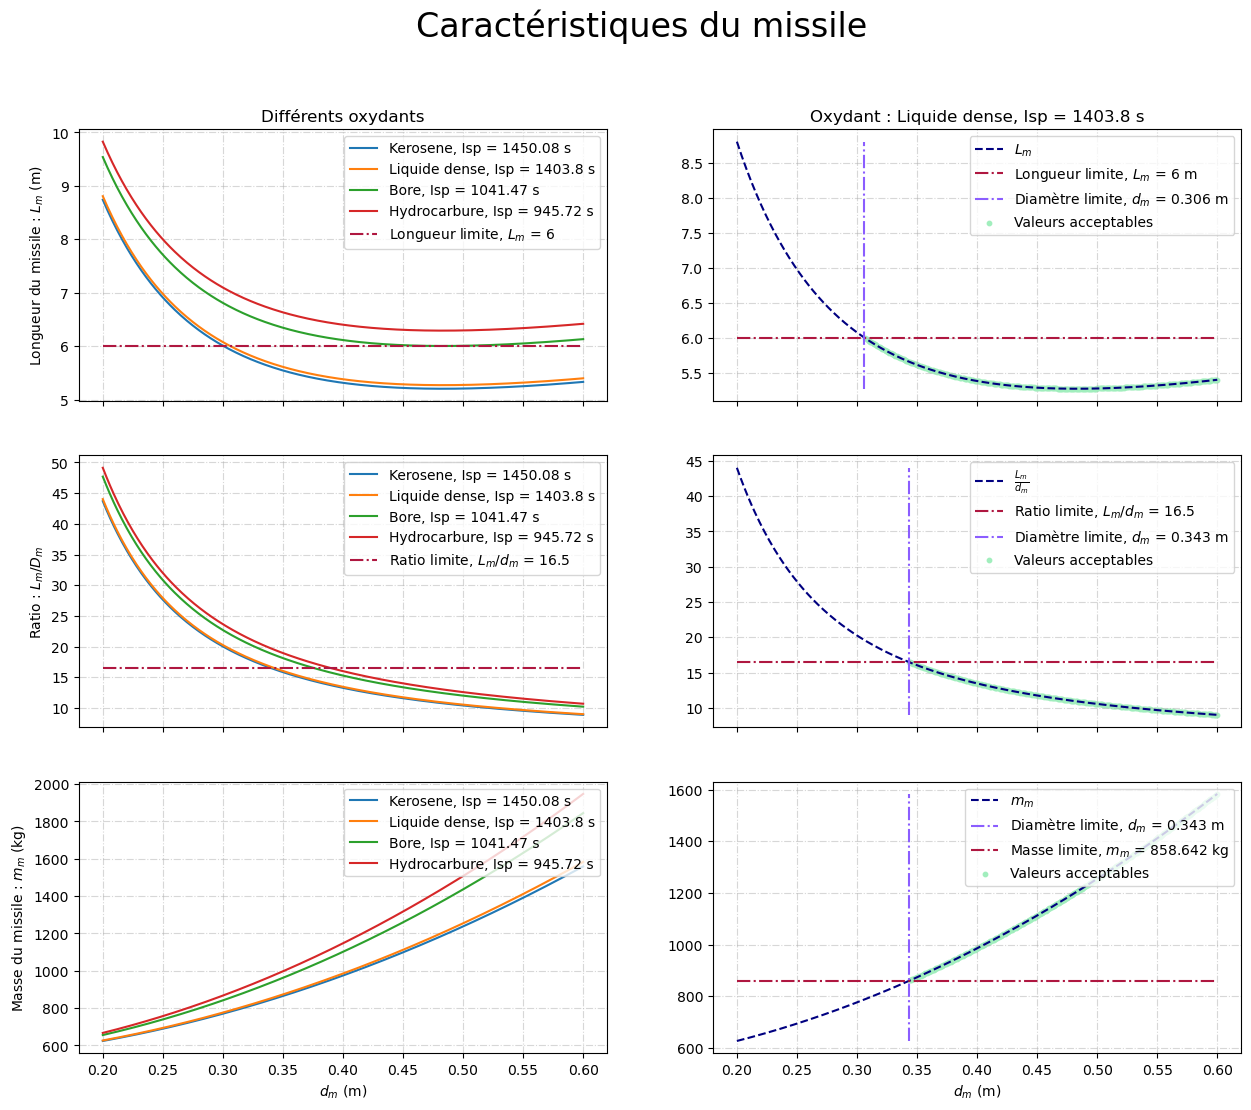

In [8]:
choosen_oxydiser = "Liquide dense"

constraint_graphs(choosen_oxydiser=choosen_oxydiser, keys_dict_main=keys_dict_main, 
                  length_tensor=length_tensor, mass_tensor=mass_tensor, 
                  d_missile=d_missile, isp_value=isp_value, 
                  cruise_data_dict=cruise_data_dict, img_path=img_path
                  )

<div class="alert alert-info" align="center"><b>DIMENSIONNEMENT DE L'OGIVE</b></div>

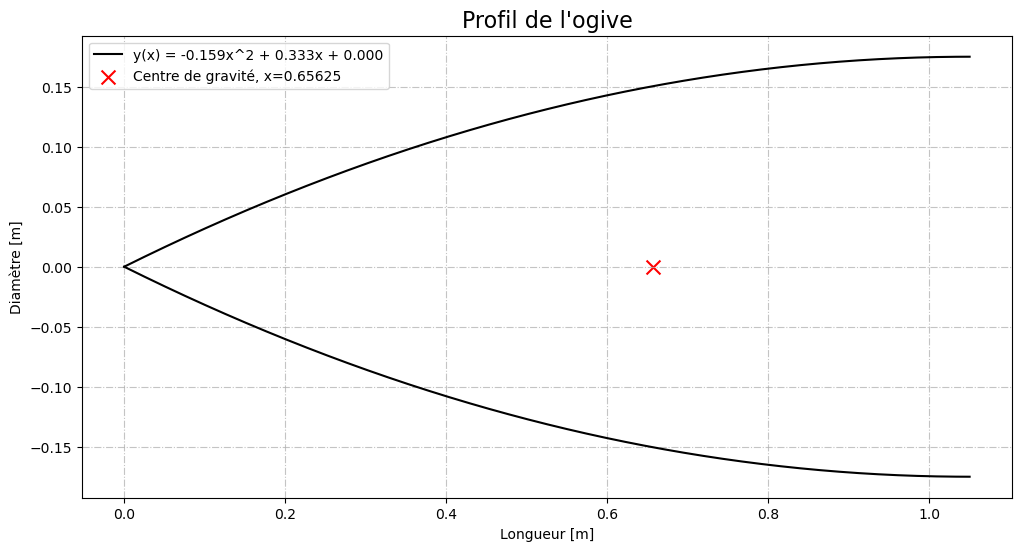

In [9]:
x_ogive, y_ogive, x_CG_ogive = generate_ogive_shape(row=row, diametre=diametre, img_path=img_path)

<div class="alert alert-info" align="center"><b>CALCUL DU CENTRE DE GRAVITÉ</b></div>

In [10]:
L_missile = row[1]
print(f"Longueur du missile : {colored(L_missile, 'blue')} m.")

Longueur du missile : 5.6116 m.


In [11]:
section_missile = generate_missile_section(row=row, x_ogive=x_ogive, y_ogive=y_ogive, x_CG_ogive=x_CG_ogive)

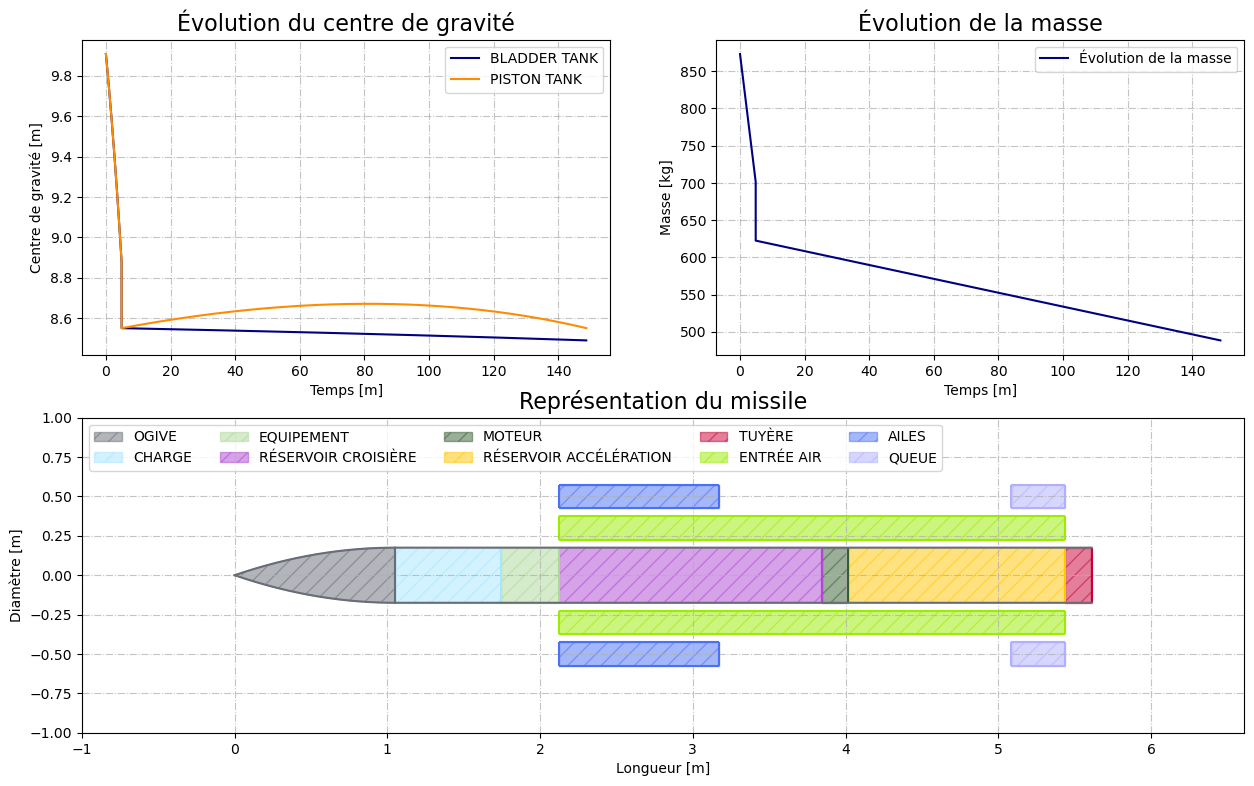

----- MASSE DE PROPERGOL POUR LA PHASE DE CROISIÈRE -----
Masse de propergol en fin de croisière : 14.895414000000017 kg
Il reste 14.89541 kg de propergol soit 10.0000 % de la masse totale.
Condition validé !


In [12]:
mc_dot = row['m_cruise_prop'] / t_cruise
ma_dot = row["m_acc_prop"] / t_acc

m_dot = {
    'ma_dot': ma_dot,
    'mc_dot': mc_dot
}

CGx_dict, mass_dict, t_tot_array = generate_CG_missile(time=time, m_dot=m_dot, 
                                                       section_missile=section_missile, 
                                                       row=row, diametre=diametre, img_path=img_path)

In [13]:
# from design_functions.generate_GIF import GenerateGIF

# GenerateGIF(CGx_dict=CGx_dict, mass_dict=mass_dict, t_tot_array=t_tot_array, 
#             diametre=diametre, row=row, section_missile=section_missile, 
#             img_path=img_path)

<div class="alert alert-info" align="center"><b>DIMENSIONNEMENT DES ENTRÉES D'AIRS</b></div>

In [14]:
thermophysic = {
    'P_inf': 101325,
    'T_inf': 288.15,
    'gamma': 1.4,
    'r': 0.4,
}

oxydizer_density = 1.0

abacusvalue = {
    'omega': 0.1278,
    'theta': 0.5556,
    'sigma': 1.688
}

airintake_params = {
    'eps': 0.925,
    'eta': 0.85,
}

sigma_rupture = 700 * 1e6

external_diameter, Upstream_Stag = Get_external_diameter(thermophysic=thermophysic, oxydizer_density=oxydizer_density,
                                                         abacusvalue=abacusvalue, airintake_params=airintake_params,
                                                         cruise_mass_flow=mc_dot)

print(f"Diamètre externe - entrée d'air : {colored(external_diameter, 'blue')} m.\n")

internal_diameter, internal_mach = Get_internal_diameter(external_diameter=external_diameter, airintake_params=airintake_params, 
                                          abacusvalue=abacusvalue)

print(f"Diamètre interne - entrée d'air : {colored(internal_diameter, 'blue')} m.")
print(f"Nombre de mach interne : {colored(internal_mach, 'blue')}.")

thickness, real_thickness = Get_AI_thickness(thermophysic=thermophysic, airintake_params=airintake_params,
                                             Upstream_Stag=Upstream_Stag, mach=internal_mach,
                                             rupture_constraint=sigma_rupture, d_missile=diametre)

print(f"\nÉpaisseur de la couche d'acier : {colored(thickness, 'blue')} m.")
print(f"Épaisseur réelle de la couche d'acier : {colored(real_thickness, 'blue')} m.")

boundary_layer_trap = diametre / 15
h_AirIntakes = internal_diameter + 2 * thickness + boundary_layer_trap
print(f"\nDimensions des entrées d'air : \n     - Longueur : {colored(row['L_AirIntakes'], 'blue')} m\n     - Hauteur : {colored(h_AirIntakes, 'blue')} m")

## ----- DONNÉES ----- ##
# provenant ABAQUES REPORT 1135 page 49
mach_secure = 2.2
theta = np.deg2rad(25)
sigma = np.deg2rad(40)

def Get_x_value(diameter, sigma):

    return diameter / (2 * np.tan(sigma))

delta_X = Get_x_value(diameter=external_diameter, sigma=sigma)
print(f"\nTaille de la souris en sortie en entrée d'entrée d'air : {colored(delta_X, 'magenta')} m.")

Diamètre externe - entrée d'air : 0.12401024495017961 m.

L hypothèse est vérifiée, nous avons donc :
    - diamètre externe : d_1 = 0.12401024495017961 m.
    - diamètre interne : d_2 = 0.14881229394021553 m.

Diamètre interne - entrée d'air : 0.14881229394021553 m.
Nombre de mach interne : 0.2950617834394905.

Épaisseur de la couche d'acier : 0.001 m.
Épaisseur réelle de la couche d'acier : 0.00013326950962723656 m.

Dimensions des entrées d'air : 
     - Longueur : 3.31257 m
     - Hauteur : 0.17414562727354888 m

Taille de la souris en sortie en entrée d'entrée d'air : 0.07389482746893228 m.


In [15]:
dX = 100.998 *1e-3

Cn_dict = {
    'Cn_F': 2.95,
    'Cn_EA': 5.95
}

xd_position = {
    'xd_F': 2.5,
}

cst_values = {
    'n': 10,
    'g': 9.80665,
    'p': 101325,
    'gamma': 1.4,
    'Mach': Mach_cruise,
    'alpha': np.deg2rad(6),
    'S_ref' : 0.25 * np.pi * diametre**2
}

Cn_dict, xd_position = Get_aero_components(cst_values=cst_values, Cn_dict=Cn_dict, xd_position=xd_position, diameter=diametre, dX=dX, type_cons='PISTON', CGx_dict=CGx_dict, mass_dict=mass_dict, row=row)

print('')
for key, value in xd_position.items():
    print(f"{key} = {value}")

print('')
for key, value in Cn_dict.items():
    print(f"{key} = {value}")

Information sans ailes et gouvernes : 
    - Position du foyer aéro : 5.078705168539328, soit --> xf_1 = 1.7775468089887645 m
    - Coefficient de portance :  8.9
    - Angle d attaque max :  : 7.979416488641967 °

Information sans gouvernes : 
    - Position du foyer aéro : 5.9269863554163935, soit --> xf_1 = 2.0744452243957374 m
    - Coefficient de portance :  12.982844912731181
    - Angle d attaque max :  : 6.010899956485441 °

xd_F = 2.5
xd_CG = 8.671517929451936
xd_EA = 6.357222857142859
xd_W = 7.776114285714288
xd_T = 14.783142857142856
Delta_d = 0.75

Cn_F = 2.95
Cn_EA = 5.95
Cn_W = 4.082844912731181
Cn_T = 8.46179322131076


In [16]:
LiftCoeff = {
    'Cn_F': 2.95,
    'Cn_EA': 5.95,
    'Cn_WF': Cn_dict['Cn_W'],
    'Cn_TF': Cn_dict['Cn_T']
}

type_cons_1 = 'PISTON'
delta_max = Get_Steering_Angle(cst_values=cst_values, CGx_dict=CGx_dict, mass_dict=mass_dict, LiftCoeff=LiftCoeff, type_cons=type_cons_1, xd_position=xd_position)
print(f'Angle de Braquage max pour le {type_cons_1} :')
print(f'    -> delta_max : {delta_max} rad soit {np.rad2deg(delta_max)}°')

Angle de Braquage max pour le PISTON :
    -> delta_max : 0.23310715309444038 rad soit 13.356056046621381°


C:\Users\plamb\AppData\Local\Temp\ipykernel_28384\3902351475.py:16: RankWarning: Polyfit may be poorly conditioned
  data_Wings = Get_Data_section(dimension=dimension_Wings, mach=Mach_cruise, section='W', angle=angle)


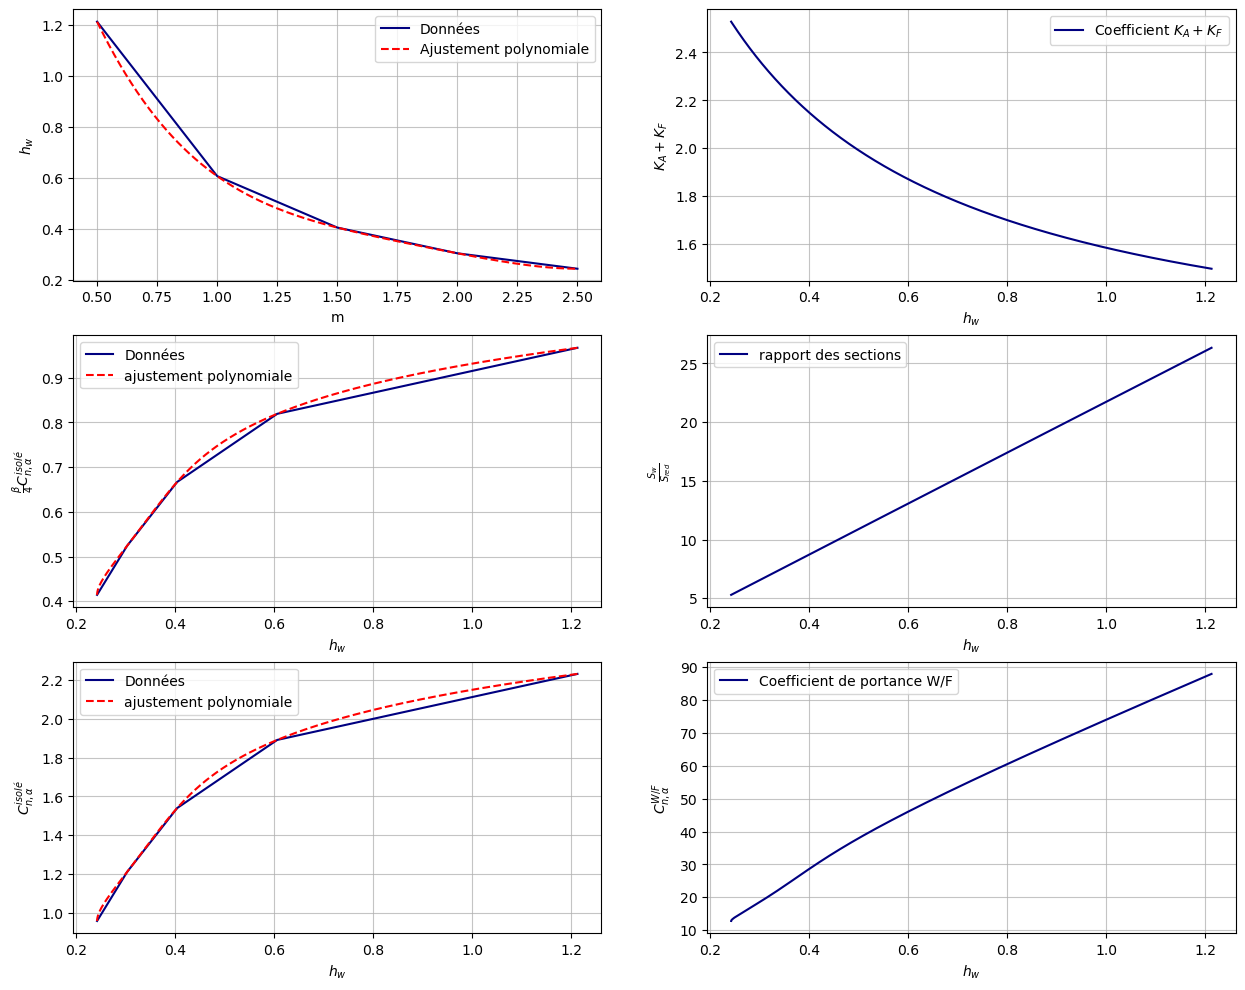

          m         h   Cn_Beta    Cn_iso  K_A + K_F    S/S_ref   Cn_alpha
0  0.500000  1.212436  0.966670  2.232429   1.497159  26.324157  87.983277
1  1.000501  0.605884  0.818895  1.891157   1.864825  13.189744  46.515980
2  1.498999  0.404388  0.666972  1.540305   2.141377   8.811031  29.062074
3  1.999499  0.303200  0.523940  1.209988   2.356887   6.609202  18.848161
4  2.500000  0.242487  0.414286  0.956752   2.528542   5.287172  12.790662

Coefficient de portance pour une aile :  1.0207112281827952
Données relatives à une aile :
    - m :  2.34984984984985
    - h_wing :  0.2503126710487886
    - Cn_alpha_WF :  13.943296386446972


In [17]:
## ----- Données des ailes ----- ##

dimension_Wings = {
    'c_section': 3*diametre,
    'diametre': diametre,
    'r_section': diametre/2 + h_AirIntakes,
    'h_AirIntakes': h_AirIntakes,
    'h_wing': None
}

angle = {
    'lambda': np.deg2rad(30),
    'phi': np.deg2rad(5)
}

data_Wings = Get_Data_section(dimension=dimension_Wings, mach=Mach_cruise, section='W', angle=angle)

m_values = [0.5, 1.0, 1.5, 2.0, 2.5]
indices = {f"idx_{int(m*10)}": np.argmin(np.abs(data_Wings['m'] - m)) for m in m_values}

data_WF = {col: [data_Wings[col][idx] for idx in indices.values()] for col in data_Wings.keys()}

data_DF_WF = pd.DataFrame(data_WF)
print(data_DF_WF)

## ----- CHOIX DE LA HAUTEUR ----- ##
Cn_1w = Cn_dict['Cn_W'] / 4
print(f"\n{colored('Coefficient de portance pour une aile : ', 'yellow')} {Cn_1w}")

idx_wing = np.argmin(np.abs(data_Wings['Cn_iso'] - Cn_1w))
m_wing = data_Wings['m'][idx_wing]
h_wing = data_Wings['h'][idx_wing]
Cn_alpha_WF = data_Wings['Cn_alpha'][idx_wing]

print(f"{colored('Données relatives à une aile :', 'red')}")
print(f"    - {colored('m : ', 'blue')} {m_wing}")
print(f"    - {colored('h_wing : ', 'blue')} {h_wing}")
print(f"    - {colored('Cn_alpha_WF : ', 'blue')} {Cn_alpha_WF}")

C:\Users\plamb\AppData\Local\Temp\ipykernel_28384\2201613504.py:16: RankWarning: Polyfit may be poorly conditioned
  data_Tails = Get_Data_section(dimension=dimension_Tails, mach=Mach_cruise, section='T', angle=angle)


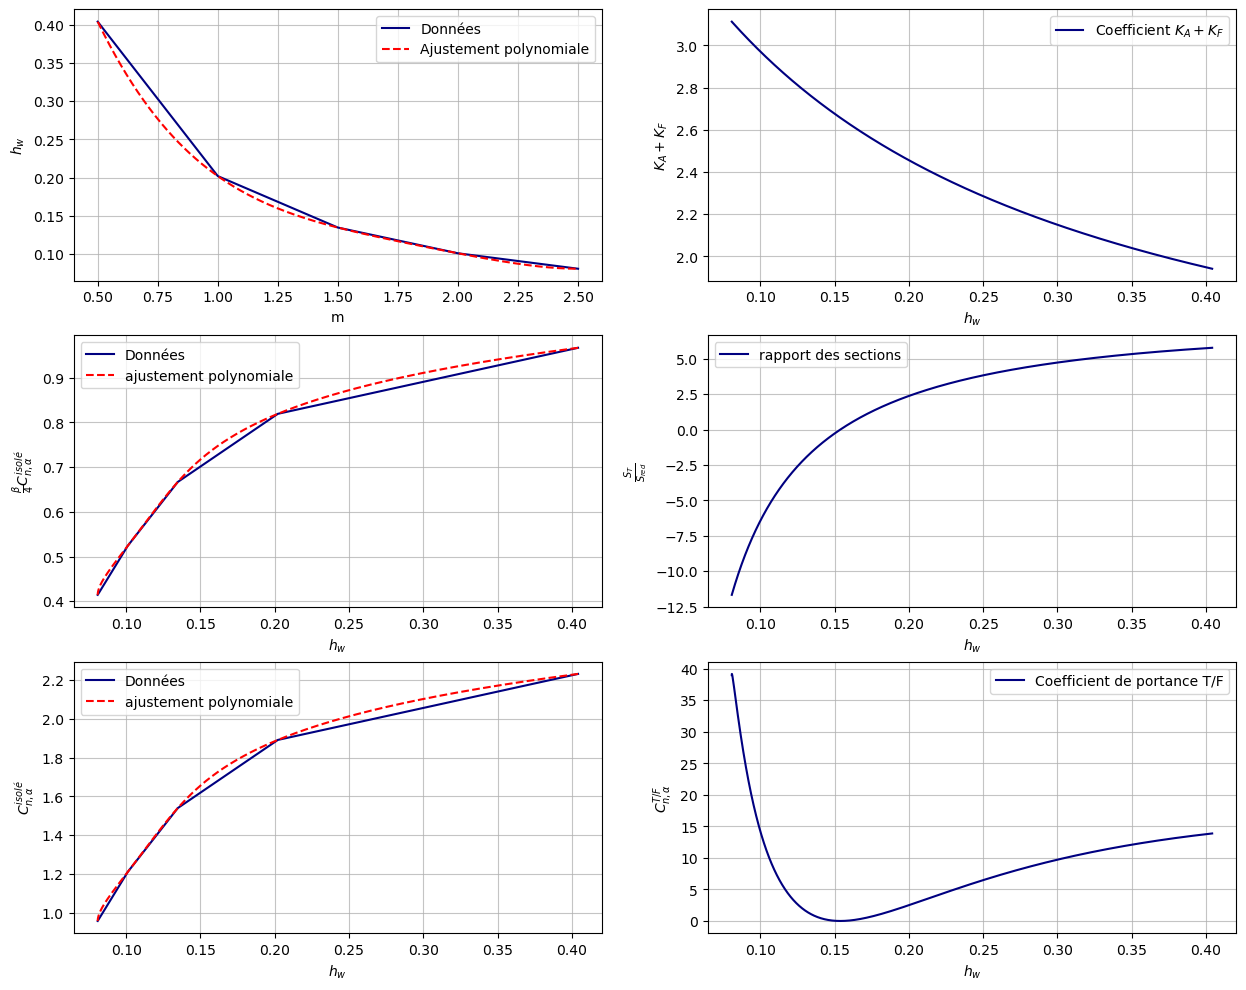

          m         h   Cn_Beta    Cn_iso  K_A + K_F    S/S_ref      K_WT  \
0  0.500000  0.404145  0.966670  2.232429   1.941491   5.769136  0.555056   
1  1.000501  0.201961  0.818895  1.891157   2.448507   2.442968  0.235041   
2  1.498999  0.134796  0.666972  1.540305   2.756766  -1.568225 -0.150881   
3  1.999499  0.101067  0.523940  1.209988   2.964204  -6.234782 -0.599856   
4  2.500000  0.080829  0.414286  0.956752   3.112682 -11.667046 -1.122501   

    Cn_alpha  
0  13.879076  
1   2.658829  
2   1.004730  
3  13.413983  
4  39.001545  

Coefficient de portance pour une gouverne :  2.11544830532769
Données relatives à une gouverne :
    - m :  0.6761761761761762
    - h_tail :  0.2988460719795006
    - Cn_alpha_TF :  10.150387999518111


In [18]:
## ----- Données des gouvernes ----- ##

dimension_Tails = {
    'c_section': diametre,
    'diametre': diametre,
    'r_section': 0.5 * (diametre + h_AirIntakes),
    'h_AirIntakes': h_AirIntakes,
    'h_wing': h_wing
}

angle = {
    'lambda': np.deg2rad(30),
    'phi': np.deg2rad(5)
}

data_Tails = Get_Data_section(dimension=dimension_Tails, mach=Mach_cruise, section='T', angle=angle)

m_values = [0.5, 1.0, 1.5, 2.0, 2.5]
indices = {f"idx_{int(m*10)}": np.argmin(np.abs(data_Tails['m'] - m)) for m in m_values}

data_TF = {col: [data_Tails[col][idx] for idx in indices.values()] for col in data_Tails.keys()}

data_DF_TF = pd.DataFrame(data_TF)
print(data_DF_TF)

## ----- CHOIX DE LA HAUTEUR ----- ##
Cn_1T = Cn_dict['Cn_T'] / 4
print(f"\n{colored('Coefficient de portance pour une gouverne : ', 'yellow')} {Cn_1T}")

idx_tail = np.argmin(np.abs(data_Tails['Cn_iso'] - Cn_1T))
m_tail = data_Tails['m'][idx_tail]
h_tail = diametre / (m_tail * np.sqrt(3))
Cn_alpha_TF = data_Tails['Cn_alpha'][idx_tail]

print(f"{colored('Données relatives à une gouverne :', 'red')}")
print(f"    - {colored('m : ', 'blue')} {m_tail}")
print(f"    - {colored('h_tail : ', 'blue')} {h_tail}")
print(f"    - {colored('Cn_alpha_TF : ', 'blue')} {Cn_alpha_TF}")

<div class="alert alert-info" align="center"><b>TRAINÉE</b></div> 

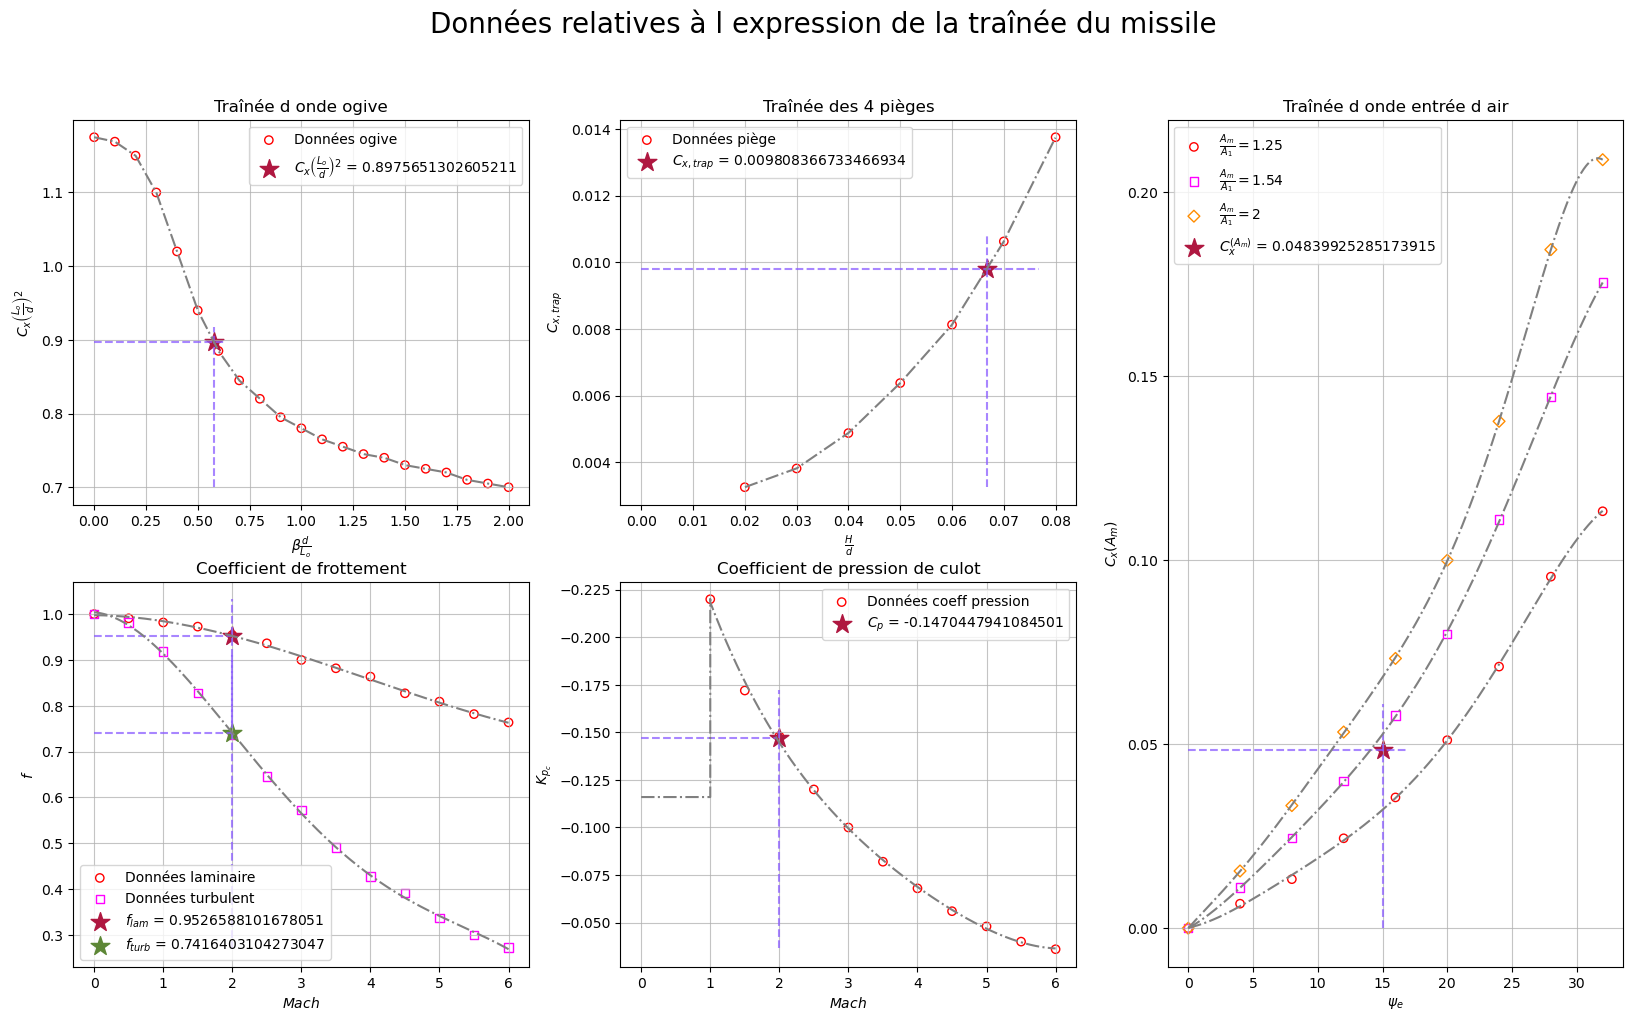

In [19]:
def Get_drag_data(target_dict, diametre_dict, row, airfoil_data):

    diametre = diametre_dict['diametre']

    ## ----- Expression des vecteurs des graphiques ----- ##

        # --> sample traînée d'onde ogive
    beta_dL_sample = np.linspace(0, 2.0, 21)
    Cx_Ld_sample = np.array([1.175, 1.169, 1.15, 1.1, 1.02, 0.94, 0.885, 0.845, 0.82, 0.795, 0.78, 0.765, 0.755, 0.745, 0.74, 0.730, 0.725, 0.72, 0.71, 0.705, 0.7])

        # --> sample traînée d'onde entrée d'air
    phi_EA_sample = np.linspace(0.0, 32.0, 9)
    ratio_circ_sample = np.array([0.0, 0.0066667, 0.013333, 0.0244442, 0.035552, 0.0511106, 0.0711104, 0.0955546, 0.1133322])
    ratio_square_sample = np.array([0.0, 0.01111, 0.0244442, 0.04, 0.0577772, 0.07999992, 0.11111, 0.144443, 0.1755538])
    ratio_diamond_sample = np.array([0.0, 0.01555554, 0.033333, 0.0533328, 0.0733326, 0.099999, 0.13777764, 0.18444426, 0.2088868])

        # --> sample traînée d'onde des pièges à couche limite
    ratio_Hd_sample = np.array([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
    Cx_trap_sample = np.array([np.nan, np.nan, 0.00325, 0.0038125, 0.004875, 0.006375, 0.008125, 0.010625, 0.01375, np.nan, np.nan])

        # --> sample traînée de frottement
    lam_sample = np.array([1.0, 0.9909, 0.98181, 0.97277, 0.95454, 0.93636, 0.89999, 0.88181, 0.86363, 0.82727, 0.80909, 0.78181, 0.76363])
    turb_sample = np.array([1.0, 0.981818, 0.91818, 0.82727, 0.73636, 0.64545, 0.572727, 0.49090, 0.42727, 0.3909, 0.3363, 0.299997, 0.27272])
    mach_sample = np.linspace(0, 6.0, 13)

        # --> sample coefficient de pression
    Cp_sample_press = np.array([-0.116, -0.116, -0.116, -0.22, -0.172, -0.148, -0.12, -0.1, -0.082, -0.068, -0.056, -0.048, -0.04, -0.036])
    mach_sample_press = np.array([0.0, 0.5, 1.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0])

        # --> abscisse vecteur
    beta_dL = np.linspace(0.0, 2.0, 500)
    phi_EA = np.linspace(0.0, 32.0, 500)
    ratio_Hd = np.linspace(0.0, 0.1, 500)
    mach_arr_frot = np.linspace(0.0, 6.0, 500)
    mach_arr_pres = np.linspace(1.0, 6.0, 450)

        # --> ordonnée vecteur
            # ogive
    interp_1 = interp1d(beta_dL_sample, Cx_Ld_sample, kind='linear')
    Cx_Ld = interp_1(beta_dL)

            # entrée d'air
    coeffs_circ = np.polyfit(phi_EA_sample, ratio_circ_sample, 5)
    coeffs_square = np.polyfit(phi_EA_sample, ratio_square_sample, 5)
    coeffs_diamond = np.polyfit(phi_EA_sample, ratio_diamond_sample, 6)
    poly_circ = np.poly1d(coeffs_circ)
    poly_square = np.poly1d(coeffs_square)
    poly_diamond = np.poly1d(coeffs_diamond)
    Cx_circ = poly_circ(phi_EA)
    Cx_square = poly_square(phi_EA)
    Cx_diamond = poly_diamond(phi_EA)

            # piège couche limite
    interp_3 = interp1d(ratio_Hd_sample, Cx_trap_sample, kind='linear')
    Cx_trap = interp_3(ratio_Hd)

            # frottement surface
    coeff_lam = np.polyfit(mach_sample, lam_sample, 3)
    fit_lam = np.poly1d(coeff_lam)
    f_lam = fit_lam(mach_arr_frot)
    coeff_turb = np.polyfit(mach_sample, turb_sample, 4)
    fit_turb = np.poly1d(coeff_turb)
    f_turb = fit_turb(mach_arr_frot)

            # pression
    arr_1, arr_2 = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0], [-0.22, -0.172, -0.148, -0.12, -0.1, -0.082, -0.068, -0.056, -0.048, -0.04, -0.036]
    coeff_CP = np.polyfit(arr_1, arr_2, 4)
    Cp_fit = np.poly1d(coeff_CP)
    Mach_arr = np.concatenate([[0.0, 0.5, 1.0, 1.0], mach_arr_pres])
    Cp_arr = np.concatenate([[-0.116, -0.116, -0.116, -0.22], Cp_fit(mach_arr_pres)])

    ## ----- Target values ----- ##

        # --> ogive
    idx_beta = np.argmin(np.abs(beta_dL - target_dict['ogive']))
    Cx_wave_ogive_prod = Cx_Ld[idx_beta]

        # --> piège couche limite
    idx_hd = np.argmin(np.abs(ratio_Hd - target_dict['trap']))
    Cx_wave_trap = Cx_trap[idx_hd]

        # --> entrée d'air
    ref_ratio = np.array([1.25, 1.54, 2.0])
    ref_Cx = np.array([Cx_circ, Cx_square, Cx_diamond])
    idx_phi = np.argmin(np.abs(phi_EA - target_dict['phi']))
    idx_insert = np.searchsorted(ref_ratio, target_dict['ratio'])
    Cx_interp = ((target_dict['ratio'] - ref_ratio[idx_insert - 1]) / (ref_ratio[idx_insert] - ref_ratio[idx_insert - 1])) * (ref_Cx[idx_insert][idx_phi] - ref_Cx[idx_insert - 1][idx_phi]) + ref_Cx[idx_insert - 1][idx_phi]

        # --> frottement
    idx_mach_reynolds = np.argmin(np.abs(mach_arr_frot - target_dict['mach']))
    f_lam_val = f_lam[idx_mach_reynolds]
    f_turb_val = f_turb[idx_mach_reynolds]

        # --> pression
    idx_mach = np.argmin(np.abs(mach_arr_pres - target_dict['mach']))
    Cp_culot = Cp_arr[idx_mach]

    graph_label = {
        'ax0': {
            'x_label': r'$\beta \frac{d}{L_{o}}$',
            'y_label': r'$C_x \left(\frac{L_o}{d}\right)^2$',
            'title': r'Traînée d onde ogive'
        },

        'ax1': {
            'x_label': r'$\frac{H}{d}$',
            'y_label': r'$C_{x, trap}$',
            'title': r'Traînée des 4 pièges'
        },

        'ax2': {
            'x_label': r'$Mach$',
            'y_label': r'$f$',
            'title': r'Coefficient de frottement'
        },

        'ax3': {
            'x_label': r'$Mach$',
            'y_label': r'$K_{p_c}$',
            'title': r'Coefficient de pression de culot'
        },

        'mergedax': {
            'x_label': r'$\psi_e$',
            'y_label': r'$C_x (A_m)$',
            'title': r'Traînée d onde entrée d air'
        },
    }

    sample_data = {

        'ax0': {
            'scat1': [beta_dL_sample, Cx_Ld_sample, 'o', 'red', 'Données ogive']
        },

        'ax1': {
            'scat1': [ratio_Hd_sample, Cx_trap_sample, 'o', 'red', 'Données piège']
        },

        'ax2': {
            'scat1': [mach_sample, lam_sample, 'o', 'red', 'Données laminaire'],
            'scat2': [mach_sample, turb_sample, 's', 'magenta', 'Données turbulent']
        },

        'ax3': {
            'scat1': [arr_1, arr_2, 'o', 'red', 'Données coeff pression']
        },

        'mergedax': {
            'scat1': [phi_EA_sample, ratio_circ_sample,'o', 'red', r'$\frac{A_m}{A_1} = 1.25$'],
            'scat2': [phi_EA_sample, ratio_square_sample,'s', 'magenta', r'$\frac{A_m}{A_1} = 1.54$'],
            'scat3': [phi_EA_sample, ratio_diamond_sample, 'D', 'darkorange', r'$\frac{A_m}{A_1} = 2$']
        },
    }

    plot_data = {
        'ax0': {
            'plot1': [beta_dL, Cx_Ld]
        },

        'ax1': {
            'plot1': [ratio_Hd, Cx_trap]
        },

        'ax2': {
            'plot1': [mach_arr_frot, f_lam],
            'plot2': [mach_arr_frot, f_turb]
        },

        'ax3': {
            'plot1': [Mach_arr, Cp_arr]
        },

        'mergedax': {
            'plot1': [phi_EA, Cx_circ],
            'plot2': [phi_EA, Cx_square],
            'plot3': [phi_EA, Cx_diamond]
        }
    }

    valid_data = {
        'ax0': {
            'sol1': [target_dict['ogive'], Cx_wave_ogive_prod, '#AF1740', r"$C_x \left(\frac{L_o}{d}\right)^2$ = " + str(Cx_wave_ogive_prod), Cx_wave_ogive_prod, beta_dL.min(), beta_dL[idx_beta] + 0.05, target_dict['ogive'], Cx_Ld.min(), Cx_Ld[idx_beta] + 0.02]
        },

        'ax1': {
            'sol1': [target_dict['trap'], Cx_wave_trap, '#AF1740', r"$C_{x, trap}$ = " + str(Cx_wave_trap), Cx_wave_trap, ratio_Hd.min(), ratio_Hd[idx_hd] + 0.01, target_dict['trap'], np.nan_to_num(np.nanmin(Cx_trap), nan=0.0), Cx_trap[idx_hd] + 0.001]
        },

        'ax2': {
            'sol1': [target_dict['mach'], f_lam_val, '#AF1740', r"$f_{lam}$ = " + str(f_lam_val), f_lam_val, mach_arr_frot.min(), mach_arr_frot[idx_mach_reynolds] + 0.01, target_dict['mach'], f_lam.min(), f_lam[idx_mach] + 0.05],
            'sol2': [target_dict['mach'], f_turb_val, '#5D8736',  r"$f_{turb}$ = " + str(f_turb_val), f_turb_val, mach_arr_frot.min(), mach_arr_frot[idx_mach_reynolds] + 0.01, target_dict['mach'], f_turb.min(), f_turb[idx_mach] + 0.01]
        },

        'ax3': {
            'sol1': [target_dict['mach'], Cp_culot, '#AF1740', r"$C_{p}$ = " + str(Cp_culot), Cp_culot, Mach_arr.min(), Mach_arr[idx_mach] + 0.01, target_dict['mach'], Cp_arr.max(), Cp_arr[idx_mach] - 0.025]
        },

        'mergedax': {
            'sol1': [target_dict['phi'], Cx_interp, '#AF1740', r"$C_{x}^{(A_m)}$ = " + str(Cx_interp), Cx_interp, phi_EA.min(), phi_EA[idx_phi] + 2, phi_EA[idx_phi], 0, Cx_interp + 0.0125]
        }
    }

    fig = plt.figure(figsize=(20, 11))
    fig.suptitle('Données relatives à l expression de la traînée du missile', fontsize=20)
    gs = GridSpec(2, 3, figure=fig)

    axis = []
    axis.append(fig.add_subplot(gs[0, 0])) 
    axis.append(fig.add_subplot(gs[0, 1])) 
    axis.append(fig.add_subplot(gs[1, 0]))
    axis.append(fig.add_subplot(gs[1, 1])) 
    axis.append(fig.add_subplot(gs[:, 2]) )

    for (idx, ax), label_graph, sample, plot, valid in zip(enumerate(axis), graph_label.values(), sample_data.values(), plot_data.values(), valid_data.values()):

        if idx == 3:
            ax.invert_yaxis()
            
        ## ----- configuration du scatter ----- ##,
        for scat in sample.values():
            ax.scatter(scat[0], scat[1], marker=scat[2], edgecolor=scat[3], facecolor='none', label=scat[4])

        ## ----- configuration bonne valeur ----- ##
        for sol in valid.values():
            ax.scatter(sol[0], sol[1], c=sol[2], marker='*', s=200, label=sol[3])
            ax.hlines(y=sol[4] ,xmin=sol[5] , xmax=sol[6] , color='#8B5DFF', linestyle='--', alpha=0.75)
            ax.vlines(x=sol[7] ,ymin=sol[8] , ymax=sol[9] , color='#8B5DFF', linestyle='--', alpha=0.75)

        ## ----- configuration du plot ----- ##
        for graph in plot.values():
            ax.plot(graph[0], graph[1], linestyle='-.', color='gray')

        ## ----- configuration du graphique ----- ##
        ax.set_title(label_graph['title'])
        ax.set_xlabel(label_graph['x_label'])
        ax.set_ylabel(label_graph['y_label'])
        ax.legend(loc='best', fontsize=10)
        ax.grid('on', alpha=0.75)

    plt.show()

    ## ----- Return Cx wave value -- ##

    internal_diameter = diametre_dict['internal_diameter']
    thickness = diametre_dict['thickness']
    beta = np.sqrt(target_dict['mach']**2 - 1)

    A_m = 0.25 * np.pi * (internal_diameter + 2*thickness)**2
    A_ref = 0.25 * np.pi * diametre**2

    Cx_wave_ogive = Cx_wave_ogive_prod * (diametre/row['L_ogive'])**2
    Cx_wave_EA = 4 * Cx_interp * (A_m/A_ref)
    Cx_wave_trap = Cx_trap[idx_hd]
    Cx_wing = 4 * (airfoil_data['aile']['K']/beta) * (airfoil_data['aile']['ratio_ec']**2) * airfoil_data['aile']['S']
    Cx_tail = 4 * (airfoil_data['gouverne']['K']/beta) * (airfoil_data['aile']['ratio_ec']**2) * airfoil_data['gouverne']['S']

    drag_wave = {
        'Cx_ogive': Cx_wave_ogive,
        'Cx_trap': Cx_wave_trap,
        'Cx_EA': Cx_wave_EA,
        'Cx_wing': Cx_wing,
        'Cx_tail': Cx_tail
    }

    Cx_wave_tot = np.sum([val for val in drag_wave.values()])
    
    drag_dict = {
        'Cx_wave': Cx_wave_tot
    }

    return drag_wave, drag_dict, Cp_culot

diametre_dict = {
    'diametre': diametre,
    'internal_diameter': internal_diameter,
    'external_diameter': external_diameter,
    'thickness': thickness
}

target_dict = {
    'ogive': np.sqrt(3) * (diametre/row['L_ogive']),
    'trap': 1 / 15,
    'phi': 15,
    'ratio': ((internal_diameter + 2*thickness) / external_diameter)**2,
    'mach': Mach_cruise
}

airfoil_data = {
    'aile': {
        'ratio_ec': 3/100,
        'K': 6,
        'S': data_Wings['S/S_ref'][idx_wing]
    },

    'gouverne': {
        'ratio_ec': 6/100,
        'K': 4,
        'S': data_Tails['S/S_ref'][idx_tail]
    }
}

drag_wave, drag_dict, Cp_culot = Get_drag_data(target_dict, diametre_dict, row, airfoil_data)

In [20]:
## Trainée onde ogive

x_wave_og = np.sqrt(3) * diametre / row['L_ogive']
print(f"{colored('Abscisse :', 'blue')} {x_wave_og}")

graph_val = 0.89
Cx_wave_ogive = graph_val * (diametre / row['L_ogive'])**2
print(f"{colored('Coeff trainée onde ogive : ', 'blue')} {Cx_wave_ogive}")

## Trainée onde une EA
A1 = 0.25 * np.pi * external_diameter**2
Am = 0.25 * np.pi * (internal_diameter + 2*thickness)**2
Am_A1 = Am/A1
print(f"\n{colored('Ratio surface : ', 'magenta')} {Am_A1}")

square_Cx = 0.0586666669
ratio_square = 1.54
circle_Cx = 0.0346666671
ratio_circle = 1.25

Cx_wave_EA = ((Am_A1 - ratio_circle) / (ratio_square - ratio_circle)) * (square_Cx - circle_Cx) + circle_Cx
print(f"{colored('Coeff traînée onde EA : ', 'magenta')} {Cx_wave_EA}")

Cx_wave_EA_tot = 4 * Cx_wave_EA * (Am/cst_values['S_ref'])
print(f"{colored('Coeff traînée onde EA tot : ', 'magenta')} {Cx_wave_EA_tot}")

## Traînée onde piège
x_wave_hd = 1/15
Cx_wave_trap = 0.00235
Cx_wave_trap_tot = 4 * Cx_wave_trap
print(f"{colored('Coeff traînée onde piège : ', 'magenta')} {Cx_wave_trap} donc pour 4 : {Cx_wave_trap_tot}")

## Traînée onde aile (bizarre)
K = 6
beta = np.sqrt(3)
ratio_ec = 3 / 100

Cx_wave_wing = (K/beta) * ratio_ec**2
print(f"\n{colored('Coeff traînée onde 1 aile : ', 'green')} {Cx_wave_wing}, pour 4 ailes : {4 * Cx_wave_wing}")
S_w = h_wing * (2 * (3 * diametre) - h_wing * np.tan(np.deg2rad(30)))
Cx_wave_wing_tot = 4 * Cx_wave_wing * (S_w/cst_values['S_ref'])
print(f"{colored('Coeff traînée onde 4 ailes sur fuselage : ', 'green')} {Cx_wave_wing_tot}")

## Traînée onde gouverne
K = 4
beta = np.sqrt(3)
ratio_ec = 6 / 100

Cx_wave_tail = (K/beta) * ratio_ec**2
print(f"\n{colored('Coeff traînée onde 1 gouverne : ', 'yellow')} {Cx_wave_tail}, pour 4 gouvernes : {4 * Cx_wave_tail}")
S_T = h_tail * (2 * (diametre) - h_tail * np.tan(np.deg2rad(30)))
Cx_wave_tail_tot = 4 * Cx_wave_tail * (S_T/cst_values['S_ref'])
print(f"{colored('Coeff traînée onde 4 gouvernes sur fuselage : ', 'yellow')} {Cx_wave_tail_tot}")

## Traînée onde totale :
Cx_wave_tot = Cx_wave_ogive + Cx_wave_EA_tot + Cx_wave_trap_tot + Cx_wave_wing_tot + Cx_wave_tail_tot
print(f"\n{colored('Cx onde total : ', 'red')} {Cx_wave_tot}")

Abscisse : 0.5773502691896256
Coeff trainée onde ogive :  0.09888888888888889

Ratio surface :  1.4789665821682563
Coeff traînée onde EA :  0.05361562546636149
Coeff traînée onde EA tot :  0.039818855315356
Coeff traînée onde piège :  0.00235 donc pour 4 : 0.0094

Coeff traînée onde 1 aile :  0.0031176914536239792, pour 4 ailes : 0.012470765814495917
Coeff traînée onde 4 ailes sur fuselage :  0.06344593345746884

Coeff traînée onde 1 gouverne :  0.008313843876330612, pour 4 gouvernes : 0.03325537550532245
Coeff traînée onde 4 gouvernes sur fuselage :  0.05448461756207678

Cx onde total :  0.2660382952237905


In [21]:
S_car = 0.5 * h_AirIntakes * (internal_diameter + 2*thickness)
S_culot = 0.25 * np.pi * (0.1 * diametre)**2 + 4 * S_car

Cx_culot = - Cp_culot * (S_culot/cst_values['S_ref'])
print(Cx_culot)

0.08174964110754211


In [22]:
row

d_m                        0.35000
L_m                        5.61160
m_m                      873.14334
m_ogive                   25.00000
m_payload                200.00000
m_equipement              55.00000
m_cruise_res              42.01271
m_cruise_prop            148.95414
m_engine_housing          10.00000
m_acc_res                 66.81892
m_acc_prop               171.82007
m_nozzle                  12.00000
m_Tails                   16.00000
m_AirIntakes              65.62500
m_Wings                   59.91250
L_ogive                    1.05000
L_payload                  0.69292
L_equipement               0.38111
L_cruise_res               1.72022
L_cruise_prop              1.54820
L_engine_housing           0.17500
L_acc_res                  1.41735
L_acc_prop                 0.99215
L_nozzle                   0.17500
L_AirIntakes               3.31257
L_Tails                    0.35000
L_Wings                    1.05000
Impulsion spécifique    1403.80000
Masse volumique     